# DMDU 2017 - Exploratory Modeling Workbench demo

## 1. Basic exploratory analysis with NetLogo

This exercise first uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EM Workbench can be used to generate scenarios across typical parametric/structural uncertainties. The example uses a NetLogo implementation of the Lotka-Volterra equations.

* We first define a model object, and test it using a single ensemble. We use 500 experiments sampled from the parameters below, and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* The EM Workbench installation includes example scripts for the different connectors, including NetLogo. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). The NetLogo connector works best with [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/6.0.1/) and requires installing JPype, preferably through the conda package manager.

* The model object can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. We use a single replication in this exercise as the model is not stochastic.

In [1]:
%matplotlib inline

import ipyparallel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, ReplicatorModel, RealParameter, TimeSeriesOutcome, Constant, ScalarOutcome,
                           perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.connectors.netlogo import NetLogoModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines
from ema_workbench.analysis.plotting_util import KDE


C:\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:8: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
C:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
from ema_workbench.em_framework.model import ReplicatorModelWd, BaseModelWd

#### NetLogo implementation

We then specify the uncertainties and outcomes. Uncertainties can use real valued parameters, integer valued parameters, and categorical parameters. For outcomes, we can use either scalar, single valued outcomes or time series outcomes. For convenience, we can also explicitly control constants in case we want to have them set to a value different from their default value.

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

#We can define common uncertainties and outcomes for each model:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

constants = [Constant('initial_prey', 50),
             Constant('initial_predators', 20)]

outcomes = [TimeSeriesOutcome('TIME'),
            TimeSeriesOutcome('predators'),
            TimeSeriesOutcome('prey')]


#Define the NetLogo model
nl_model = NetLogoModel('NetLogo', wd='./PredPrey/', model_file='PredPrey.nlogo')
nl_model.run_length = int(365 / 0.25)
nl_model.replications = 1
nl_model.uncertainties = uncertainties
nl_model.constants = constants
nl_model.outcomes = outcomes


We then execute the models for 500 experiments. By default, Latin Hypercube sampling (LHS) is used.

In [4]:
from ema_workbench import (IpyparallelEvaluator, MultiprocessingEvaluator, ema_logging, Policy,
                           perform_experiments)

with MultiprocessingEvaluator(nl_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=500)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[SpawnPoolWorker-6/INFO] finalizing
[SpawnPoolWorker-2/INFO] finalizing
[SpawnPoolWorker-7/INFO] finalizing
[SpawnPoolWorker-3/INFO] finalizing
[SpawnPoolWorker-1/INFO] finalizing
[SpawnPoolWorker-8/INFO] finalizing
[SpawnPoolWorker-5/INFO] finalizing
[SpawnPoolWorker-4/INFO] finalizing


In [6]:
experiments, outcomes = results
print(experiments.shape) #500 scenarios
print(outcomes['prey'].shape) #500 scenarios x 1 replication x 1461 time steps

(500,)
(500, 1, 1461)


We can then use basic matplotlib functions to visualize the results, by plotting the 'prey' outcome for each model. We use logical indexing to select the experiments corresponding to each model. The [:,0,:] index on the outcomes lets us select the single replication which was used in this example, so that we go back to a 2D array (experiments, time).

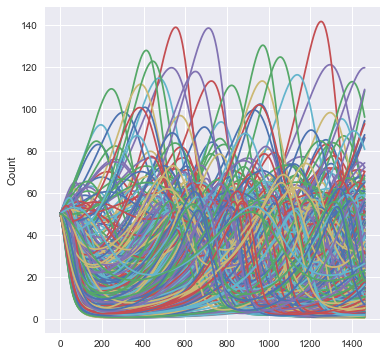

In [7]:
fig, ax = plt.subplots(1)


ax.plot(outcomes['prey'][:,0,:].T)
ax.set_ylabel('Count')

fig.set_size_inches(6,6)
plt.show()

The line graph shows that although the models behave quite differently depending on the experiments, the results are graphically identical across the 4 models.

## 2. Sensitivity analysis and scenario discovery

To better understand the behavior of the model, we can use techniques for sensitivity analysis and scenario discovery. In this example, we directly use the SALib library (Herman & Usher, 2017) to sample experiments for a Sobol variance-based global sensitivity analysis. We also do a simple example of scenario discovery with the PRIM module included in the Workbench.

In [8]:
from SALib.analyze import sobol

#Helper function to convert uncertainty definition to a SALib problem
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

In this case, we specify Sobol sampling to call the SALib sampler, and execute a larger number of experiments with the Python implementation of the model. The sampler automatically generates an appropriate number of samples _n*(2p+2)_, where _p_ is the number of input parameters; _n_ is a baseline sample size which should be large enough to stabilize the estimation of the indices. By default, the sampler assumes second-order interaction indices are to be computed.

For use later in the analysis, we also convert the model uncertainties to a SALib problem definition dictionary, which includes uncertainty bounds and the name/number of variables.

In [9]:
problem = get_SALib_problem(nl_model.uncertainties)
#p=4: we need to sample n*(2p+2) experiments
results_sobol = perform_experiments(nl_model, scenarios=100, uncertainty_sampling=SOBOL)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [11]:
problem

{'bounds': [(0.0005, 0.003), (0.001, 0.004), (0.04, 0.08), (0.015, 0.035)],
 'names': ['predation_rate',
  'predator_efficiency',
  'predator_loss_rate',
  'prey_birth_rate'],
 'num_vars': 4}

Given the highly cyclical behavior of the outcomes over time, using a single point in time to analyze the outcomes would make it difficult to draw conclusions. Instead, we take the mean and standard deviation over time, using the 'prey' outcome as an example.

In [12]:
experiments, outcomes = results_sobol

prey_mean = np.mean(outcomes['prey'][:,0,:],axis=1)
prey_std = np.std(outcomes['prey'][:,0,:],axis=1)

We can first use scatter plots to visualize relationships between each input and the mean prey count over time, adding the Pearson correlation coefficient for each.

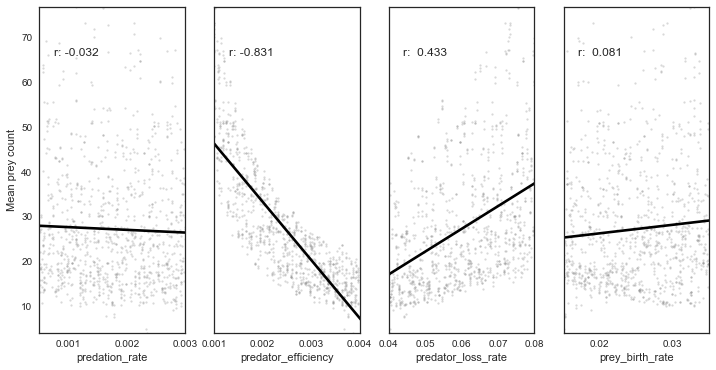

In [13]:
%matplotlib inline
import seaborn as sns
import scipy
sns.set_style('white')
fig, ax = plt.subplots(1,problem['num_vars'],sharey=True)

y = prey_mean
for i, n in enumerate(problem['names']):
    
    x = experiments[n]
    sns.regplot(x, y, ax=ax[i], ci=None, color='k',scatter_kws={'alpha':0.3, 'color':'gray', 's':5})
    pearson = scipy.stats.pearsonr(x, y)
    ax[i].annotate('r: {:6.3f}'.format(pearson[0]), xy=(0.1, 0.85), xycoords='axes fraction', fontsize=12)
    ax[i].set_xlim(problem['bounds'][i])
    ax[i].set_xlabel(n)

ax[0].set_ylabel('Mean prey count')
ax[0].set_ylim([np.min(y),np.max(y)])   
fig.set_size_inches(12,6,forward=True)  
plt.show()

We can then try fitting a multivariable linear regression to the mean prey count, using the statsmodels library (available through the pip package manager). In this case, the R2 value indicates a fairly accurate fit.

In [14]:
import statsmodels.api as sm

X = pd.DataFrame(experiments).drop(['model','policy'], inplace=False, axis=1)
X_0 = sm.add_constant(X)

est = sm.OLS(prey_mean, X_0.astype(float)).fit()
print(est.summary())

C:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1308.
Date:                Wed, 21 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:18:20   Log-Likelihood:                -3013.5
No. Observations:                1000   AIC:                             6039.
Df Residuals:                     994   BIC:                             6068.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  29.1795    

We then use SALib's Sobol analysis module to evaluate each input's contribution to output variance.

In [15]:
Si = sobol.analyze(problem, prey_mean, 
                   calc_second_order=True, print_to_console=False)

In [16]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

,S1,S1_conf,ST,ST_conf
predation_rate,-0.003280,0.017002,0.003750,0.001335
predator_efficiency,0.763142,0.290746,0.931028,0.272826
predator_loss_rate,0.203162,0.137144,0.242048,0.101568
prey_birth_rate,0.027994,0.024891,0.009326,0.004057


The results confirm the visual interpretation of the output, with the predator_efficiency variable contributing most of the output variance.

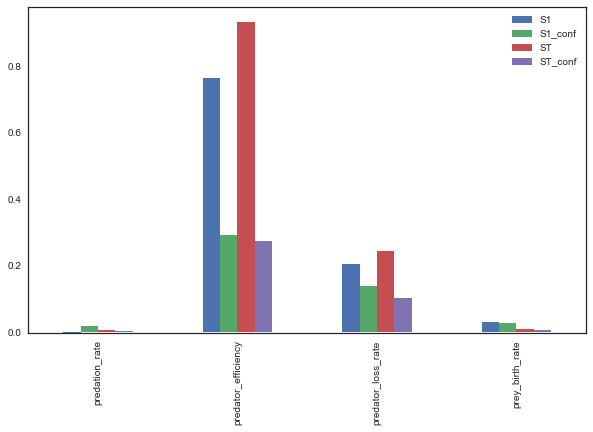

In [17]:
sns.set_style('white')
fig, ax = plt.subplots(1)
Si_df.plot(kind='bar', ax=ax)
fig.set_size_inches(10,6)

Finally, as a simple example of scenario discovery, we use PRIM to investigate the combinations of uncertainties which cause a certain output region of interest. Assuming we are interested in cases with a mean prey count over 40:

In [18]:
from ema_workbench.analysis import prim

x = experiments
y = prey_mean > 40
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 1000 points remaining, containing 170 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.111, coverage: 0.6529411764705882, density: 1.0 restricted_dimensions: 3.0


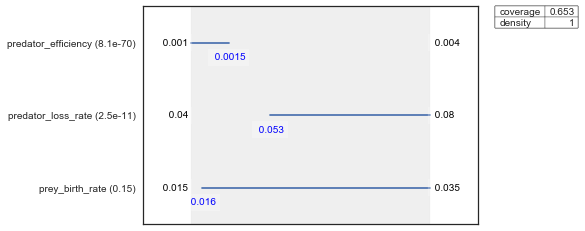

In [19]:
box1.inspect(style='graph')
plt.show()